In [8]:
import warnings
warnings.filterwarnings('ignore')

###### 테크닉 41. 데이터 읽고 수정

In [9]:
import pandas as pd
customer = pd.read_csv('customer_join.csv')
uselog_months = pd.read_csv('use_log_months.csv')

In [10]:
year_months = list(uselog_months["연월"].unique())
uselog = pd.DataFrame()
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"]==year_months[i]]
    tmp.rename(columns={"count":"count_0"}, inplace=True)
    tmp_before = uselog_months.loc[uselog_months["연월"]==year_months[i-1]]
    del tmp_before["연월"]
    tmp_before.rename(columns={"count":"count_1"}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)
uselog.head()

,연월,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


###### 테크닉 42. 탈퇴 전월의 탈퇴 고객 데이터 작성

In [11]:
from dateutil.relativedelta import relativedelta
exit_customer = customer.loc[customer["is_deleted"]==1]
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
for i in range(len(exit_customer)):
    exit_customer["exit_date"].iloc[i] = exit_customer["end_date"].iloc[i] - relativedelta(months=1)

exit_customer["연월"] = exit_customer["exit_date"].dt.strftime("%Y%m")
uselog["연월"] = uselog["연월"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id", "연월"], how="left")
print(len(uselog))
exit_uselog.head()


33851


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# 결측치 제거하기

exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

1104
1104


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,일반,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,일반,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,일반,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


###### 테크닉 43. 지속회원 데이터 작성

In [15]:
conti_customer = customer.loc[customer["is_deleted"]==0]
conti_uselog = pd.merge(uselog, conti_customer, on=["customer_id"], how="left")
print(len(conti_uselog))
conti_uselog = conti_uselog.dropna(subset=["name"])        # name칼럼 결손 데이터 및 탈퇴회원 제거
print(len(conti_uselog))

33851
27422


In [16]:
# 데이터 섞고 중복제거(지속 회원 데이터도 회원당 1개가 되게 언더샘플링)
conti_uselog = conti_uselog.sample(frac=1).reset_index(drop=True)
conti_uselog = conti_uselog.drop_duplicates(subset="customer_id")
print(len(conti_uselog))
conti_uselog.head()

2842


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201903,TS106731,4,6.0,XXXX,C03,M,2015-06-01,NaN,CA1,...,야간,6000.0,일반,4.416667,5.0,7.0,2.0,1.0,2019-04-30,46.0
1,201811,GD648354,8,5.0,XXXXX,C01,M,2016-11-01,NaN,CA1,...,종일,10500.0,일반,5.083333,5.0,8.0,2.0,1.0,2019-04-30,29.0
2,201903,HD666225,2,4.0,XXXXX,C02,F,2016-12-01,NaN,CA1,...,주간,7500.0,일반,5.500000,5.5,9.0,2.0,1.0,2019-04-30,28.0
3,201811,IK359438,6,2.0,XXXXX,C03,F,2017-03-01,NaN,CA1,...,야간,6000.0,일반,5.250000,5.5,7.0,2.0,1.0,2019-04-30,25.0
4,201902,HD307544,7,8.0,XX,C01,M,2017-03-01,NaN,CA1,...,종일,10500.0,일반,5.916667,6.0,8.0,3.0,1.0,2019-04-30,25.0


In [17]:
# 지속 회원 데이터와 탈퇴 회원 데이터 세로로 결합
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True)
print(len(predict_data))
predict_data.head()

3946


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201903,TS106731,4,6.0,XXXX,C03,M,2015-06-01,NaN,CA1,...,6000.0,일반,4.416667,5.0,7.0,2.0,1.0,2019-04-30,46.0,NaN
1,201811,GD648354,8,5.0,XXXXX,C01,M,2016-11-01,NaN,CA1,...,10500.0,일반,5.083333,5.0,8.0,2.0,1.0,2019-04-30,29.0,NaN
2,201903,HD666225,2,4.0,XXXXX,C02,F,2016-12-01,NaN,CA1,...,7500.0,일반,5.500000,5.5,9.0,2.0,1.0,2019-04-30,28.0,NaN
3,201811,IK359438,6,2.0,XXXXX,C03,F,2017-03-01,NaN,CA1,...,6000.0,일반,5.250000,5.5,7.0,2.0,1.0,2019-04-30,25.0,NaN
4,201902,HD307544,7,8.0,XX,C01,M,2017-03-01,NaN,CA1,...,10500.0,일반,5.916667,6.0,8.0,3.0,1.0,2019-04-30,25.0,NaN


###### 테크닉 44. 예측할 달의 재적 기간 작성

In [21]:
predict_data["period"] = 0
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = int(delta.years*12 + delta.months)
predict_data.head()

,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201903,TS106731,4,6.0,XXXX,C03,M,2015-06-01,NaN,CA1,...,4.416667,5.0,7.0,2.0,1.0,2019-04-30,46.0,NaN,45,2019-03-01
1,201811,GD648354,8,5.0,XXXXX,C01,M,2016-11-01,NaN,CA1,...,5.083333,5.0,8.0,2.0,1.0,2019-04-30,29.0,NaN,24,2018-11-01
2,201903,HD666225,2,4.0,XXXXX,C02,F,2016-12-01,NaN,CA1,...,5.500000,5.5,9.0,2.0,1.0,2019-04-30,28.0,NaN,27,2019-03-01
3,201811,IK359438,6,2.0,XXXXX,C03,F,2017-03-01,NaN,CA1,...,5.250000,5.5,7.0,2.0,1.0,2019-04-30,25.0,NaN,20,2018-11-01
4,201902,HD307544,7,8.0,XX,C01,M,2017-03-01,NaN,CA1,...,5.916667,6.0,8.0,3.0,1.0,2019-04-30,25.0,NaN,23,2019-02-01


###### 테크닉 45. 결측치 제거

In [22]:
# 결측치 수 파악
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1               258
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

In [24]:
# 결손 데이터 제거
predict_data = predict_data.dropna(subset=["count_1"])
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2636
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2636
period                  0
now_date                0
dtype: int64

###### 원핫 인코딩 One-Hot-Encoding

In [25]:
# 컴퓨터 1
# 마우스 2
# 키보드 3
# 모니터 4
# 책상   5

# 책상 5 > 컴퓨터 1 ???
# 마우스 2 모니터 4의 평균은 3 키보드 ???
# 2.5???

# 데이터의 연속성에 대한 문제 발생...
# 연속적인 특성, 순서가 없는 데이터이기 때문에 발생

# 원핫 인코딩 One-Hot-Encoding 기법이 필요...

In [26]:
data_dic = {'label' : ['Apple', 'Samsung', 'LG', 'Samsung']}
df = pd.DataFrame(data_dic)

In [27]:
df

,label
0,Apple
1,Samsung
2,LG
3,Samsung


In [28]:
pd_encoded = pd.get_dummies(df['label'])
pd_encoded

,Apple,LG,Samsung
0,1,0,0
1,0,0,1
2,0,1,0
3,0,0,1


In [29]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()

In [30]:
skl_encoded = oh.fit_transform(df)

In [32]:
print(skl_encoded)

# 1의 위치를 표현, 즉 0이 아닌 값의 위치를 의미

  (0, 0)	1.0
  (1, 2)	1.0
  (2, 1)	1.0
  (3, 2)	1.0


###### 테크닉 46. 문자열 변수를 처리할 수 있게 가공

In [41]:
target_col = ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period", "is_deleted"]
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,일반,야간,M,6.0,1.0,45,0.0
1,일반,종일,M,5.0,1.0,24,0.0
2,일반,주간,F,4.0,1.0,27,0.0
3,일반,야간,F,2.0,1.0,20,0.0
4,일반,종일,M,8.0,1.0,23,0.0


In [42]:
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_일반,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_야간,class_name_종일,class_name_주간,gender_F,gender_M
0,6.0,1.0,45,0.0,1,0,0,1,0,0,0,1
1,5.0,1.0,24,0.0,1,0,0,0,1,0,0,1
2,4.0,1.0,27,0.0,1,0,0,0,0,1,1,0
3,2.0,1.0,20,0.0,1,0,0,1,0,0,1,0
4,8.0,1.0,23,0.0,1,0,0,0,1,0,0,1


In [43]:
del predict_data["campaign_name_일반"]
del predict_data["class_name_야간"]
del predict_data["gender_M"]
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_종일,class_name_주간,gender_F
0,6.0,1.0,45,0.0,0,0,0,0,0
1,5.0,1.0,24,0.0,0,0,1,0,0
2,4.0,1.0,27,0.0,0,0,0,1,1
3,2.0,1.0,20,0.0,0,0,0,0,1
4,8.0,1.0,23,0.0,0,0,1,0,0


###### 테크닉 47. 의사결정 트리 사용해 탈퇴 예측 모델 구축

In [45]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

In [60]:
exit = predict_data.loc[predict_data["is_deleted"]==1]
conti = predict_data.loc[predict_data["is_deleted"]==0].sample(len(exit))
print(len(exit))
print(len(conti))

1052
1052


In [56]:
X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

In [57]:
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)

[1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0.

In [62]:
# 실제 정답과 비교

results_test = pd.DataFrame({"y_test":y_test, "y_pred":y_test_pred})    # 데이터프레임으로 저장
results_test.head()

,y_test,y_pred
523,1.0,1.0
525,1.0,1.0
183,1.0,1.0
869,1.0,1.0
1323,0.0,0.0


###### 테크닉 48. 예측 모델을 평가하고 모델 튜닝하기

In [65]:
correct = len(results_test.loc[results_test["y_test"]==results_test["y_pred"]])
data_count = len(results_test)
score_test = correct / data_count
print(score_test)

0.9106463878326996


In [66]:
print(model.score(X_test, y_test))      # 평가용 데이터 이용 예측 성능
print(model.score(X_train, y_train))    # 학습용 데이터 이용 예측 성능

0.9106463878326996
0.9759188846641318


In [67]:
X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)

In [68]:
# 트리의 깊이를 얕게하여 모델 단순화

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.94106463878327
0.9271229404309252


In [71]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50, 15))

<Figure size 3600x1080 with 0 Axes>

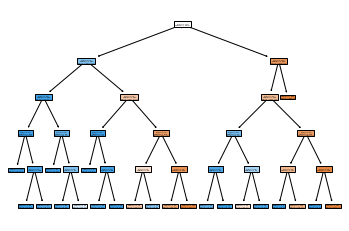

In [72]:
from sklearn import tree

tree.plot_tree(model, impurity = False, filled=True)

plt.show()

###### 테크닉 49. 모델에 기여하는 변수 확인

In [73]:
importance = pd.DataFrame({"feature_names": X.columns, "coefficient": model.feature_importances_ })
importance

,feature_names,coefficient
0,count_1,0.361444
1,routine_flg,0.140631
2,period,0.485324
3,campaign_name_입회비무료,0.000000
4,campaign_name_입회비반액할인,0.004041
5,class_name_종일,0.007682
6,class_name_주간,0.000000
7,gender_F,0.000877


###### 테크닉 50. 회원 탈퇴 예측

In [74]:
count_1 = 3
routing_flg = 1
period = 10
campaign_name = "입회비무료"
class_name = "종일"
gender = "M"

In [77]:
if campaign_name == "입회비반값할인":
    campaign_name_list = [1, 0]
elif campaign_name == "입회비무료":
    campaign_name_list = [0, 1]
elif campaign_name == "일반":
    campaign_name_list = [0, 0]
if class_name == "종일":
    class_name_list = [0, 0]
elif class_name == "주간":
    class_name_list = [1, 0]
elif class_name == "야간":
    class_name_list = [0, 1]
if gender == "F":
    gender_list = [1]
elif gender == "M":
    gender_list = [0]

input_data = [count_1, routing_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)

In [78]:
print(model.predict([input_data]))
print(model.predict_proba([input_data]))

[1.]
[[0. 1.]]
